<a href="https://colab.research.google.com/github/biini/ai06project4/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 기본 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import imageio
import os
import PIL
import tensorflow as tf
import time
from IPython import display
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline 

In [ ]:
tf.version.VERSION

'2.8.0'

## 이미지 불러오기
데이터 출처: https://www.kaggle.com/kritanjalijain/fashion-anchor-cloth-pairs

### 이미지 npz파일로 저장
- 이미지 파일의 용량이 크기 때문에 매번 구글 드라이브에서 이미지를 불러오는 것 보단, npz파일로 저장 후 사용하는 것이 편리하다.

In [ ]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from skimage.transform import resize

dir = '/content/drive/MyDrive/Colab Notebooks/Project/dcgan/dress_dataset/cloths'

img = imageio.imread(f"{dir}/dress2.png")
print(img.dtype)
print(img.shape)
print(img.shape == (640, 480, 3))
print(img.shape == (641, 480, 3))
print(img.max(), img.min())

uint8
(641, 480, 3)
False
True
255 2


>이미지가 (640, 480, 3)인 이미지와 (641, 480, 3)인 이미지로 크기가 다른 이미지들이 있어 바로 npz파일로 저장할 경우 원하는 shape이 나오지 않기 때문에 이미지 사이즈를 조절해 줄 것이다.

>또한 (640, 480, 3)크기로 조절할 경우 이미지를 resize하는 과정에서 RAM이 초과하기 때문에 사이즈를 줄여 저장해야 한다.

In [ ]:
import os
import imageio
from skimage.transform import resize

#이미지 경로
dir = '/content/drive/MyDrive/Colab Notebooks/Project/dcgan/dress_dataset/cloths'

img_array = []

for file_name in os.listdir(dir):
    img = imageio.imread(f"{dir}/{file_name}") # 이미지 파일 열기
    img = resize(img,(160, 120, 3)) #이미지 사이즈 줄이기
    
    array = np.array(img)
    img_array.append(array)

In [ ]:
# .npz파일로 저장
np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/Project/dcgan/dress_dataset/dress.npz', img=img_array)

### 저장한 npz파일 다운 후 로드

In [2]:
# !gdown 'Access denied with the following error:' 에러 해결
!pip install --upgrade --no-cache-dir gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=cfde4cc0d5de53c233fdfd6bc4159fb16382794a46958d595232f784d8ca8b7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-xe6n8p5e/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [3]:
# npz파일 다운로드
# https://drive.google.com/file/d/1KatvX0sG1ailYVfz4Er_jEMiDI_NO_UO/view?usp=sharing
!gdown --id 1KatvX0sG1ailYVfz4Er_jEMiDI_NO_UO

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1KatvX0sG1ailYVfz4Er_jEMiDI_NO_UO
To: /content/dress.npz
100% 1.21G/1.21G [00:09<00:00, 123MB/s]


In [4]:
# 다운 받은 데이터 load
images = np.load('/content/dress.npz', allow_pickle=True)
images

### 로드한 데이터 확인

In [5]:
list(images.keys())

['img']

In [6]:
# train_images에 이미지 데이터 할당
train_images = images['img']

In [7]:
# 이미지 shpae 확인
train_images.shape

(12692, 160, 120, 3)

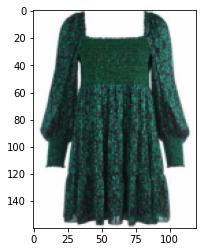

In [8]:
# 이미지 확인
plt.imshow(train_images[3])
plt.show()

In [9]:
# 데이터 타입, 최소값, 최대값 확인
print('train_images dtype:', train_images.dtype)
print('train_images min num:', train_images.min())
print('train_images max num:', train_images.max())

train_images dtype: float64
train_images min num: 0.0
train_images max num: 1.0


In [10]:
# 데이터 확인
print(train_images[train_images != 0][:10])
print(train_images[train_images != 1][:10])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.99901961 0.99901961 0.99607843 0.99803922 0.99803922 0.99607843
 0.99705882 0.99705882 0.99607843 0.99607843]


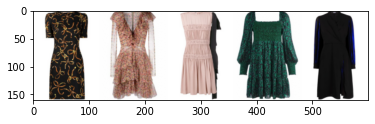

In [11]:
# 0번~4번 이미지 확인
plt.imshow(train_images[:5].transpose(1,0,2,3).reshape(160,-1,3))
plt.show()

In [12]:
# generator output layer에서 activation function으로 tanh를 사용하기 때문에 [-1,1]로 이미지 정규화
train_images = (train_images - 0.5) / 0.5

In [13]:
# 데이터 확인
print('train_images min num:', train_images.min())
print('train_images max num:', train_images.max())
print(train_images[train_images != 0][:10])
print(train_images[train_images != 1][:10])

train_images min num: -1.0
train_images max num: 1.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.99803922 0.99803922 0.99215686 0.99607843 0.99607843 0.99215686
 0.99411765 0.99411765 0.99215686 0.99215686]


## GAN
### Genreator, Discriminator 만들기

### Generator

In [14]:
# random noise의 latent dimesion
LATENT_DIM = 100

# Generator의 weight initializer
WEIGHT_INT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# 채널 개수
CHANNELS = 3


In [34]:
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

def make_generator_model():
    # Squential모델 생성
    model = Sequential(name = 'generator')

    # reshape하기 위한 준비
    # (100,)데이터를 (20*15*256)의 1D로 바꿔줌
    model.add(layers.Dense(20*15*256, input_dim=LATENT_DIM)) # 첫번째 layer에만 input shape 알려주기
    model.add(layers.ReLU())

    # 1D -> 3D로 reshape
    model.add(layers.Reshape((20, 15, 256)))

    # 20x30으로 upsample
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INT))
    model.add(layers.ReLU())

    # 80x60으로 upsample
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INT))
    model.add(layers.ReLU())

    # 160x120, activation function으로 tanh
    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh'))

    return model

In [35]:
generator = make_generator_model()

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 76800)             7756800   
                                                                 
 re_lu_15 (ReLU)             (None, 76800)             0         
                                                                 
 reshape_6 (Reshape)         (None, 20, 15, 256)       0         
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 40, 30, 128)      524416    
 Transpose)                                                      
                                                                 
 re_lu_16 (ReLU)             (None, 40, 30, 128)       0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 80, 60, 64)       131136    
 Transpose)                                              

In [38]:
def make_discriminator_model(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = tf.keras.Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # 1st set
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                                     input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2nd set
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3rd set
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last outputting a single value for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [39]:
# build the discriminator model
discriminator = make_discriminator_model(160, 120, 3)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 80, 60, 64)        3136      
                                                                 
 batch_normalization_4 (Batc  (None, 80, 60, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 80, 60, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 30, 128)       131200    
                                                                 
 batch_normalization_5 (Batc  (None, 40, 30, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 40, 30, 128)     

In [40]:
class DCGAN(keras.Model): ##########################################코드 해석#############################
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile() # compile overriding
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0)
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # 2. Train the generator (do not update weights of the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (labels as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training = True)
            pred_fake = self.discriminator(fake_images, training = True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss" : self.d_loss_metric.result(), "g_loss" : self.g_loss_metric.result()}

In [41]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during training
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')
        plt.savefig(f'epoch_{epoch:0.3f}.png') # ValueError: Precision not allowed in integer format 에러로 d -> f로 바꿈
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [42]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

In [43]:
D_LR = 0.0001
G_LR = 0.0003

dcgan.compile(
    d_optimizer = keras.optimizers.Adam(learning_rate = D_LR, beta_1 = 0.5),
    g_optimizer = keras.optimizers.Adam(learning_rate = G_LR, beta_1 = 0.5),
    loss_fn = keras.losses.BinaryCrossentropy(),
)

Epoch 1/100
397/397 [==============================] - ETA: 0s - d_loss: -0.7668 - g_loss: 18.2042

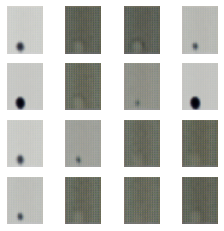

397/397 [==============================] - 28s 65ms/step - d_loss: -0.7668 - g_loss: 18.2042
Epoch 2/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.1338 - g_loss: 11.3606

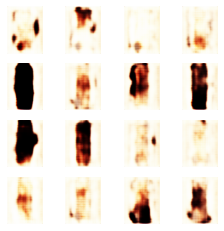

397/397 [==============================] - 26s 64ms/step - d_loss: 0.1331 - g_loss: 11.3475
Epoch 3/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.3417 - g_loss: 5.8314

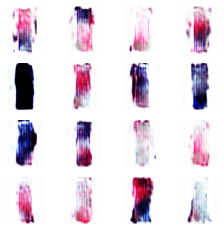

397/397 [==============================] - 26s 64ms/step - d_loss: 0.3409 - g_loss: 5.8295
Epoch 4/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.3347 - g_loss: 4.5296

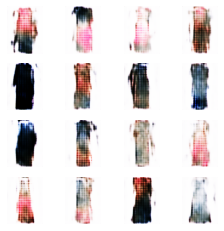

397/397 [==============================] - 26s 64ms/step - d_loss: 0.3352 - g_loss: 4.5186
Epoch 5/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.3400 - g_loss: 4.3439

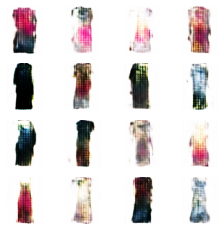

397/397 [==============================] - 26s 65ms/step - d_loss: 0.3418 - g_loss: 4.3549
Epoch 6/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.3858 - g_loss: 3.4245

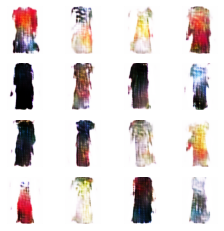

397/397 [==============================] - 26s 64ms/step - d_loss: 0.3862 - g_loss: 3.4206
Epoch 7/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.4590 - g_loss: 3.2047

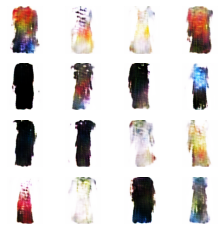

397/397 [==============================] - 26s 64ms/step - d_loss: 0.4593 - g_loss: 3.1980
Epoch 8/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.5332 - g_loss: 2.9384

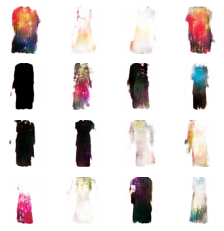

397/397 [==============================] - 26s 64ms/step - d_loss: 0.5326 - g_loss: 2.9411
Epoch 9/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.5975 - g_loss: 2.6523

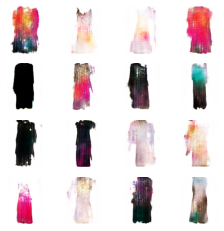

397/397 [==============================] - 26s 65ms/step - d_loss: 0.5969 - g_loss: 2.6474
Epoch 10/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7026 - g_loss: 2.1968

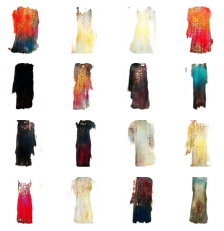

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7033 - g_loss: 2.1916
Epoch 11/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7546 - g_loss: 1.7896

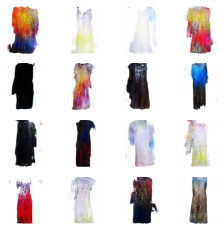

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7538 - g_loss: 1.7889
Epoch 12/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7853 - g_loss: 1.6939

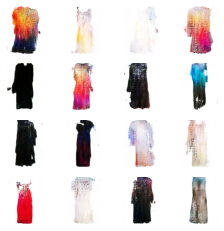

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7850 - g_loss: 1.6952
Epoch 13/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7682 - g_loss: 1.4439

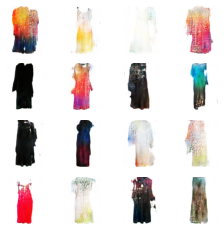

397/397 [==============================] - 26s 65ms/step - d_loss: 0.7685 - g_loss: 1.4414
Epoch 14/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7674 - g_loss: 1.3419

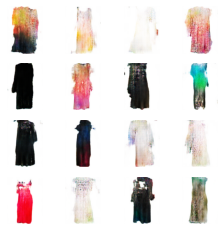

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7668 - g_loss: 1.3423
Epoch 15/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7710 - g_loss: 1.3215

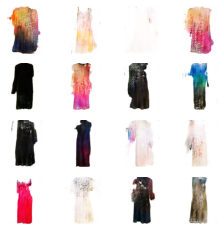

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7712 - g_loss: 1.3197
Epoch 16/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7611 - g_loss: 1.2800

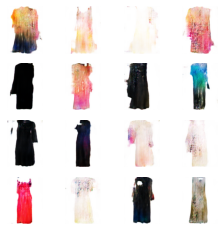

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7618 - g_loss: 1.2777
Epoch 17/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7761 - g_loss: 1.2448

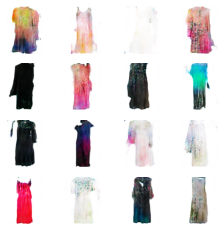

397/397 [==============================] - 26s 65ms/step - d_loss: 0.7759 - g_loss: 1.2456
Epoch 18/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7794 - g_loss: 1.2006

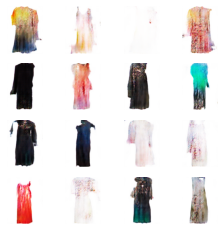

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7795 - g_loss: 1.2031
Epoch 19/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7709 - g_loss: 1.1763

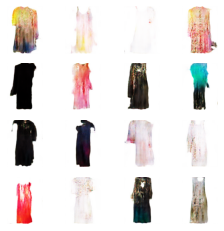

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7712 - g_loss: 1.1761
Epoch 20/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7743 - g_loss: 1.1326

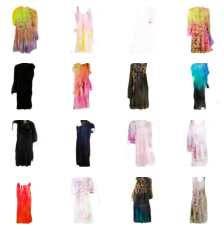

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7740 - g_loss: 1.1342
Epoch 21/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7776 - g_loss: 1.1020

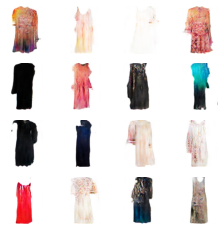

397/397 [==============================] - 26s 65ms/step - d_loss: 0.7781 - g_loss: 1.1004
Epoch 22/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7699 - g_loss: 1.0789

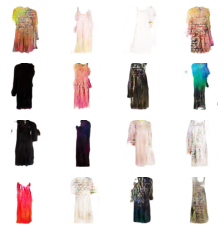

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7703 - g_loss: 1.0801
Epoch 23/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7784 - g_loss: 1.0602

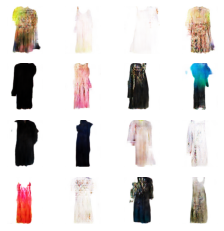

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7788 - g_loss: 1.0595
Epoch 24/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7759 - g_loss: 1.0287

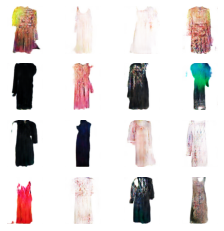

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7762 - g_loss: 1.0284
Epoch 25/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7711 - g_loss: 1.0164

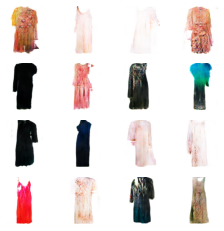

397/397 [==============================] - 26s 65ms/step - d_loss: 0.7711 - g_loss: 1.0147
Epoch 26/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7769 - g_loss: 1.0173

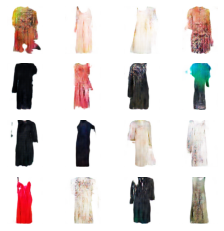

397/397 [==============================] - 26s 65ms/step - d_loss: 0.7767 - g_loss: 1.0164
Epoch 27/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7716 - g_loss: 0.9945

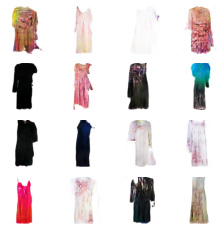

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7716 - g_loss: 0.9951
Epoch 28/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7651 - g_loss: 0.9916

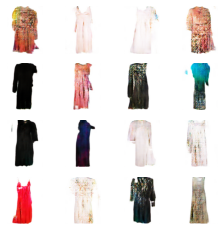

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7657 - g_loss: 0.9942
Epoch 29/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7653 - g_loss: 0.9819

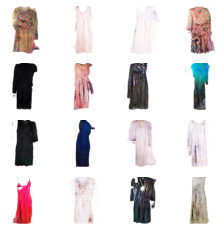

397/397 [==============================] - 26s 65ms/step - d_loss: 0.7651 - g_loss: 0.9825
Epoch 30/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7594 - g_loss: 0.9686

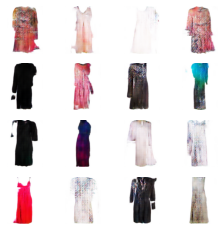

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7596 - g_loss: 0.9685
Epoch 31/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7589 - g_loss: 0.9627

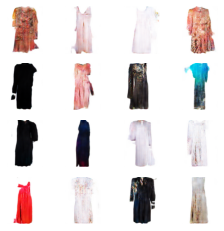

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7591 - g_loss: 0.9619
Epoch 32/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7602 - g_loss: 0.9837

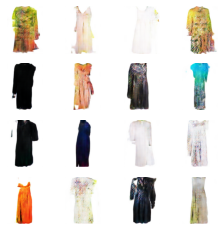

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7605 - g_loss: 0.9855
Epoch 33/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7543 - g_loss: 0.9727

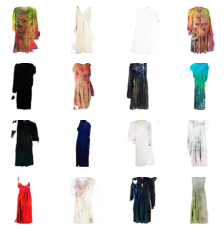

397/397 [==============================] - 26s 65ms/step - d_loss: 0.7549 - g_loss: 0.9709
Epoch 34/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7487 - g_loss: 0.9477

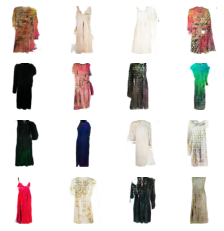

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7484 - g_loss: 0.9477
Epoch 35/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7582 - g_loss: 0.9706

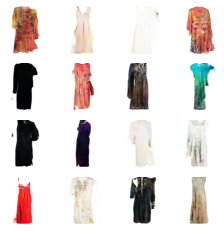

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7577 - g_loss: 0.9723
Epoch 36/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7529 - g_loss: 0.9694

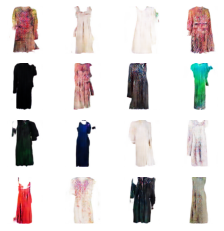

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7529 - g_loss: 0.9690
Epoch 37/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7424 - g_loss: 0.9544

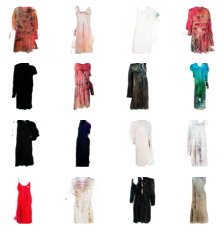

397/397 [==============================] - 26s 65ms/step - d_loss: 0.7423 - g_loss: 0.9537
Epoch 38/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7471 - g_loss: 0.9676

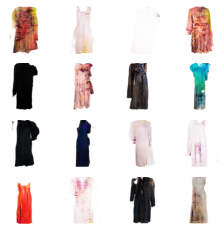

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7469 - g_loss: 0.9672
Epoch 39/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7365 - g_loss: 0.9403

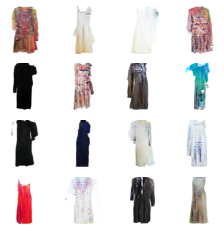

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7363 - g_loss: 0.9392
Epoch 40/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7370 - g_loss: 0.9422

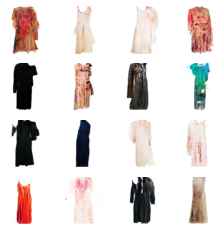

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7374 - g_loss: 0.9406
Epoch 41/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7337 - g_loss: 0.9442

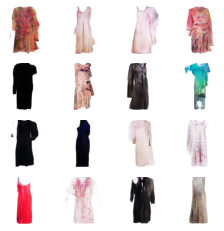

397/397 [==============================] - 26s 65ms/step - d_loss: 0.7336 - g_loss: 0.9446
Epoch 42/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7380 - g_loss: 0.9396

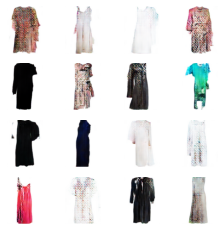

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7383 - g_loss: 0.9401
Epoch 43/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7374 - g_loss: 0.9471

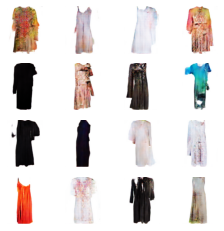

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7375 - g_loss: 0.9476
Epoch 44/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7324 - g_loss: 0.9410

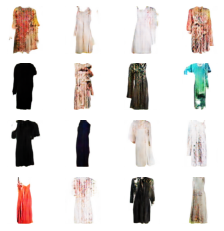

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7323 - g_loss: 0.9412
Epoch 45/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7301 - g_loss: 0.9362

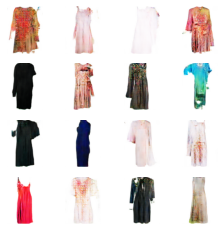

397/397 [==============================] - 26s 65ms/step - d_loss: 0.7294 - g_loss: 0.9369
Epoch 46/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7218 - g_loss: 0.9384

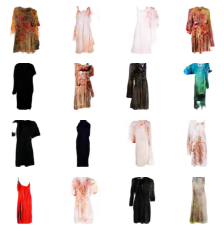

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7221 - g_loss: 0.9365
Epoch 47/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7368 - g_loss: 0.9480

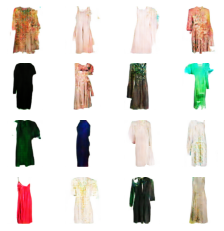

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7367 - g_loss: 0.9486
Epoch 48/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7283 - g_loss: 0.9482

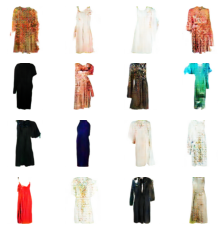

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7283 - g_loss: 0.9490
Epoch 49/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7288 - g_loss: 0.9555

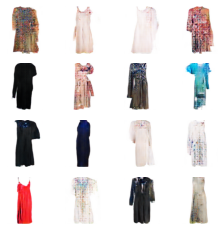

397/397 [==============================] - 26s 65ms/step - d_loss: 0.7287 - g_loss: 0.9568
Epoch 50/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7188 - g_loss: 0.9476

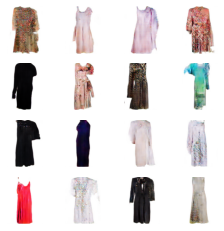

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7188 - g_loss: 0.9476
Epoch 51/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7300 - g_loss: 0.9663

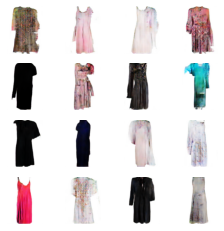

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7300 - g_loss: 0.9664
Epoch 52/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7148 - g_loss: 0.9552

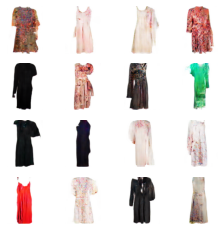

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7149 - g_loss: 0.9543
Epoch 53/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7125 - g_loss: 0.9605

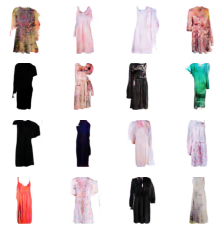

397/397 [==============================] - 26s 65ms/step - d_loss: 0.7123 - g_loss: 0.9604
Epoch 54/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7126 - g_loss: 0.9767

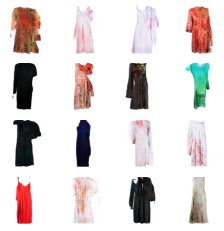

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7121 - g_loss: 0.9773
Epoch 55/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7169 - g_loss: 0.9703

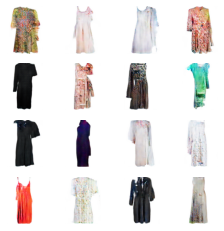

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7166 - g_loss: 0.9709
Epoch 56/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7097 - g_loss: 0.9655

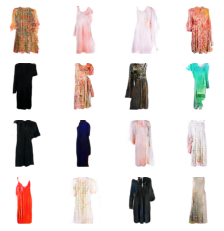

397/397 [==============================] - 26s 65ms/step - d_loss: 0.7101 - g_loss: 0.9645
Epoch 57/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7150 - g_loss: 0.9765

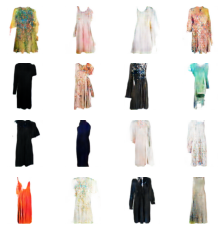

397/397 [==============================] - 26s 65ms/step - d_loss: 0.7146 - g_loss: 0.9771
Epoch 58/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.7038 - g_loss: 0.9781

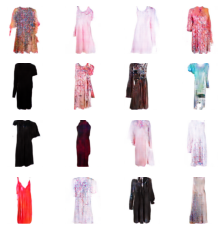

397/397 [==============================] - 26s 64ms/step - d_loss: 0.7037 - g_loss: 0.9781
Epoch 59/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6964 - g_loss: 1.0007

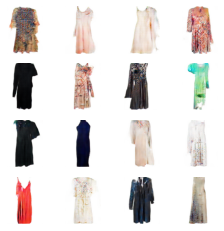

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6964 - g_loss: 1.0017
Epoch 60/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6917 - g_loss: 0.9936

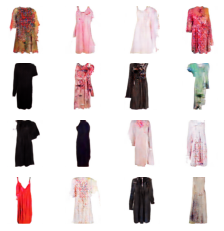

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6918 - g_loss: 0.9952
Epoch 61/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6935 - g_loss: 1.0005

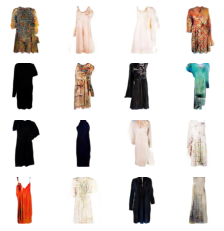

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6935 - g_loss: 1.0012
Epoch 62/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6972 - g_loss: 1.0167

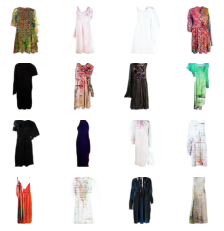

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6973 - g_loss: 1.0170
Epoch 63/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6915 - g_loss: 1.0277

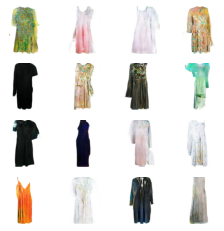

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6911 - g_loss: 1.0287
Epoch 64/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6877 - g_loss: 1.0236

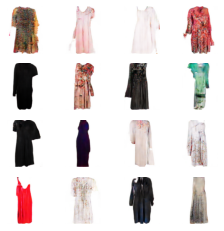

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6878 - g_loss: 1.0231
Epoch 65/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6810 - g_loss: 1.0544

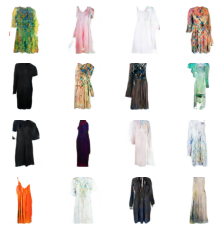

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6809 - g_loss: 1.0546
Epoch 66/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6896 - g_loss: 1.0400

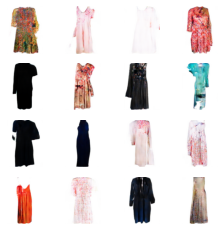

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6894 - g_loss: 1.0408
Epoch 67/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6815 - g_loss: 1.0504

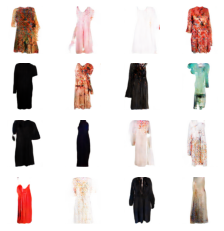

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6815 - g_loss: 1.0498
Epoch 68/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6690 - g_loss: 1.0622

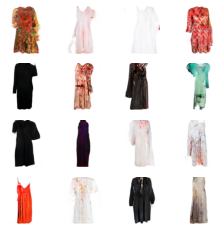

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6693 - g_loss: 1.0622
Epoch 69/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6781 - g_loss: 1.0742

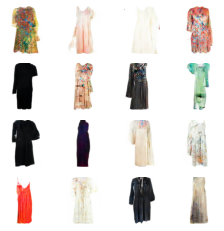

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6790 - g_loss: 1.0727
Epoch 70/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6674 - g_loss: 1.0947

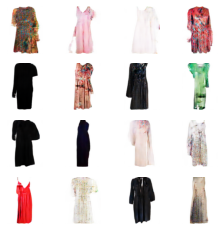

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6674 - g_loss: 1.0957
Epoch 71/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6817 - g_loss: 1.0951

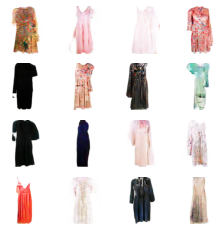

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6816 - g_loss: 1.0952
Epoch 72/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6543 - g_loss: 1.0767

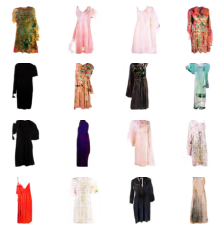

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6545 - g_loss: 1.0755
Epoch 73/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6577 - g_loss: 1.1131

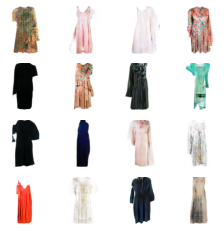

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6579 - g_loss: 1.1141
Epoch 74/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6559 - g_loss: 1.1130

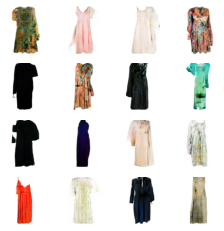

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6559 - g_loss: 1.1135
Epoch 75/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6589 - g_loss: 1.1320

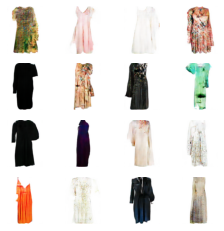

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6586 - g_loss: 1.1332
Epoch 76/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6433 - g_loss: 1.1558

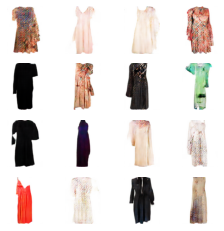

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6431 - g_loss: 1.1559
Epoch 77/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6522 - g_loss: 1.1656

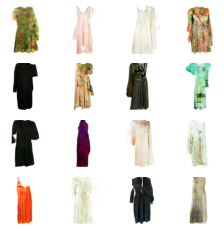

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6519 - g_loss: 1.1680
Epoch 78/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6425 - g_loss: 1.1702

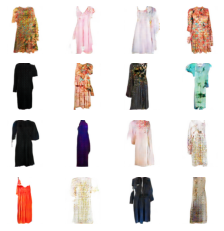

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6426 - g_loss: 1.1712
Epoch 79/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6413 - g_loss: 1.1662

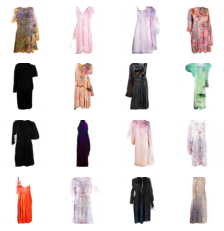

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6412 - g_loss: 1.1665
Epoch 80/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6423 - g_loss: 1.2015

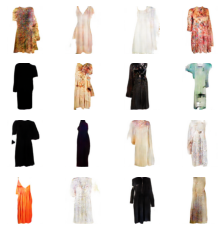

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6422 - g_loss: 1.2009
Epoch 81/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6317 - g_loss: 1.2148

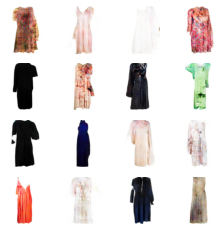

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6321 - g_loss: 1.2129
Epoch 82/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6260 - g_loss: 1.2123

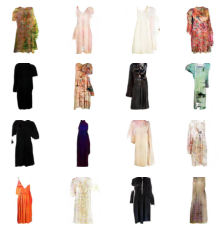

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6261 - g_loss: 1.2120
Epoch 83/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6296 - g_loss: 1.2166

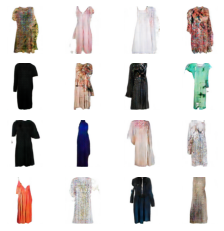

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6303 - g_loss: 1.2155
Epoch 84/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6396 - g_loss: 1.2398

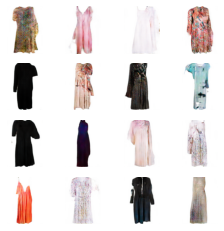

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6395 - g_loss: 1.2385
Epoch 85/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6235 - g_loss: 1.2258

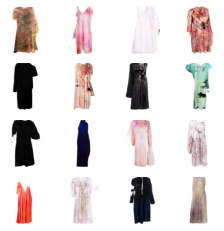

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6245 - g_loss: 1.2248
Epoch 86/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6223 - g_loss: 1.2530

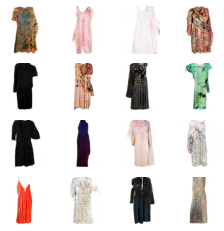

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6224 - g_loss: 1.2525
Epoch 87/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6301 - g_loss: 1.2571

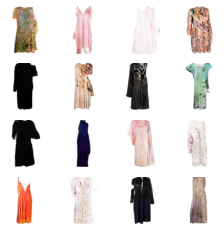

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6294 - g_loss: 1.2592
Epoch 88/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6122 - g_loss: 1.2499

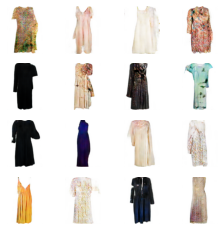

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6122 - g_loss: 1.2504
Epoch 89/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6151 - g_loss: 1.2773

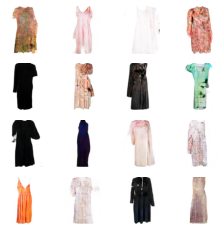

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6150 - g_loss: 1.2768
Epoch 90/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6072 - g_loss: 1.3064

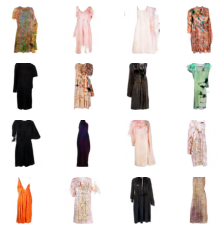

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6075 - g_loss: 1.3065
Epoch 91/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6107 - g_loss: 1.2992

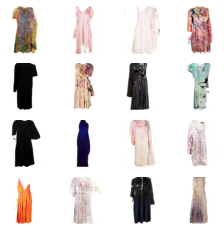

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6108 - g_loss: 1.2976
Epoch 92/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6147 - g_loss: 1.3251

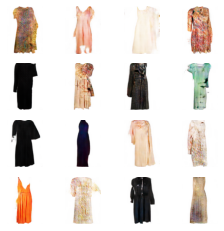

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6144 - g_loss: 1.3256
Epoch 93/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6125 - g_loss: 1.2821

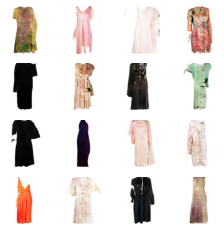

397/397 [==============================] - 26s 65ms/step - d_loss: 0.6124 - g_loss: 1.2825
Epoch 94/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.5951 - g_loss: 1.3348

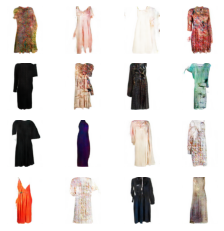

397/397 [==============================] - 26s 64ms/step - d_loss: 0.5950 - g_loss: 1.3334
Epoch 95/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6046 - g_loss: 1.3338

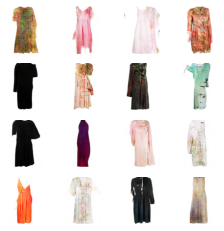

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6048 - g_loss: 1.3337
Epoch 96/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.6003 - g_loss: 1.3480

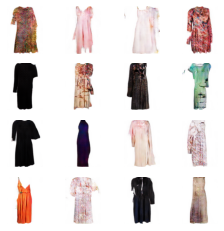

397/397 [==============================] - 26s 64ms/step - d_loss: 0.6004 - g_loss: 1.3488
Epoch 97/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.5997 - g_loss: 1.3582

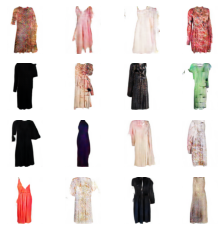

397/397 [==============================] - 26s 65ms/step - d_loss: 0.5997 - g_loss: 1.3586
Epoch 98/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.5957 - g_loss: 1.3684

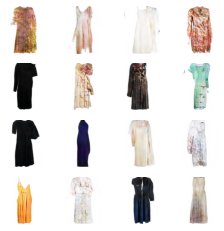

397/397 [==============================] - 26s 64ms/step - d_loss: 0.5958 - g_loss: 1.3684
Epoch 99/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.5841 - g_loss: 1.3843

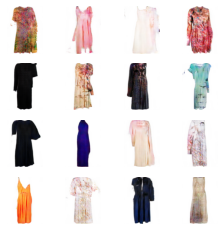

397/397 [==============================] - 26s 64ms/step - d_loss: 0.5847 - g_loss: 1.3820
Epoch 100/100
396/397 [============================>.] - ETA: 0s - d_loss: 0.5811 - g_loss: 1.3910

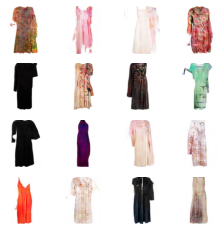

397/397 [==============================] - 26s 64ms/step - d_loss: 0.5808 - g_loss: 1.3907


In [44]:
NUM_EPOCHS = 100

dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])